# **CRISP-DM — Portfolio & Long-Lived Series (PS3→PS4→PS5)**

## **Business Understanding**

---

### **Problem**
We want to understand how sequel performance changes across PlayStation generations and which publishers show the most stable results over time using `PlayStationSales.csv`. Based on the dataset coverage, the analysis focuses on PS3 and PS4.

### **Main Questions**
- Q1: How do sequels perform when a series stays on the same console versus when it moves from `PS3 → PS4`?
- Q2: Which publishers show the most stable performance across multiple years on PS3 and PS4?

### **Objectives**
- Build a normalised `PerformanceIndex` from `Total Sales` within each `Console × Year`.
- Infer `Series` and `SequelOrder` and compute sequel deltas between Part N and Part N+1.
- Rank publishers by stability using median performance and variability.

### **Scope**
**In:** PS3/PS4 games, `Name`, `Console`, `Release Date`, `Publisher`, `Total Sales`, regional sales.  
**Out:** PS5 modelling, exact forecasts, and causal claims.

### **Success Criteria**
- Clean reproducible pipeline.
- Sequel results shown for `SameConsole` vs `PS3 → PS4`.
- A clear top-10 stability view for publishers using the normalised index.


## **Data Understanding**

---

### **What we do**
- Load `PlayStationSales.csv`.
- Parse `Release Date` and extract `Year`.
- Inspect missing values and basic distributions.
- Use simple visuals to justify later filtering choices.

### **Key views**
- Number of titles by `Console`.
- Releases per year by `Console`.
- Total sales per year.

### **What we expect to confirm**
- Which consoles have enough coverage for sequel analysis.
- Which years have reliable sales coverage.


/tmp/ipython-input-1036467851.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_raw["Release Date"] = pd.to_datetime(df_raw["Release Date"], errors="coerce")


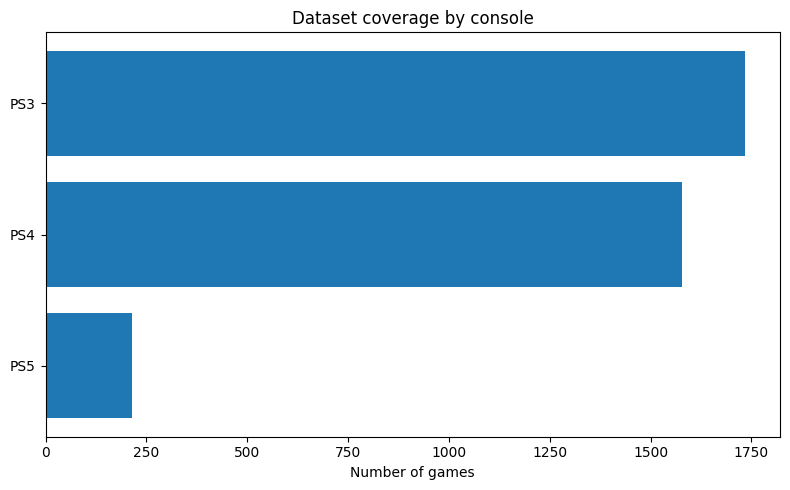

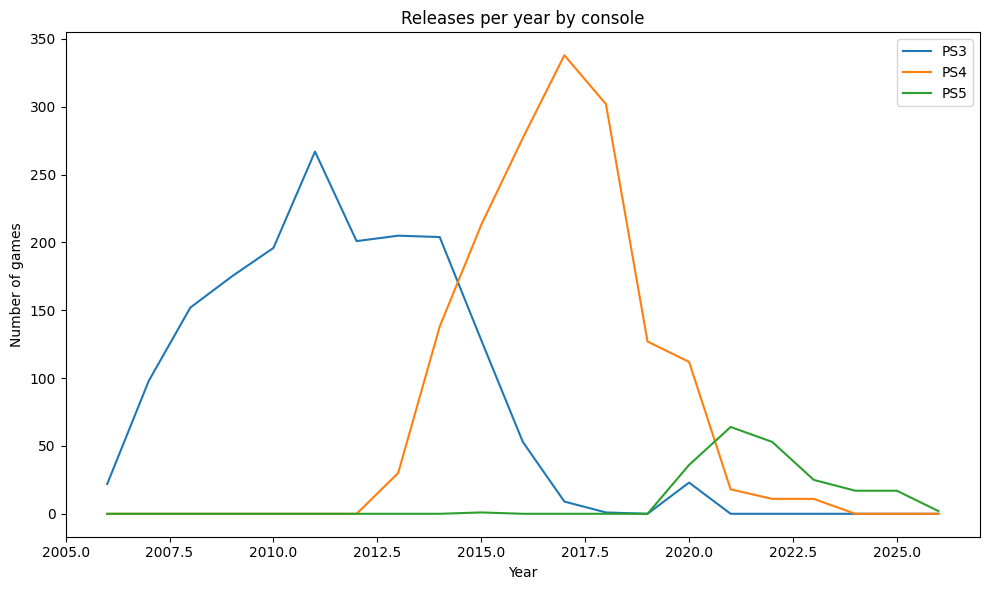

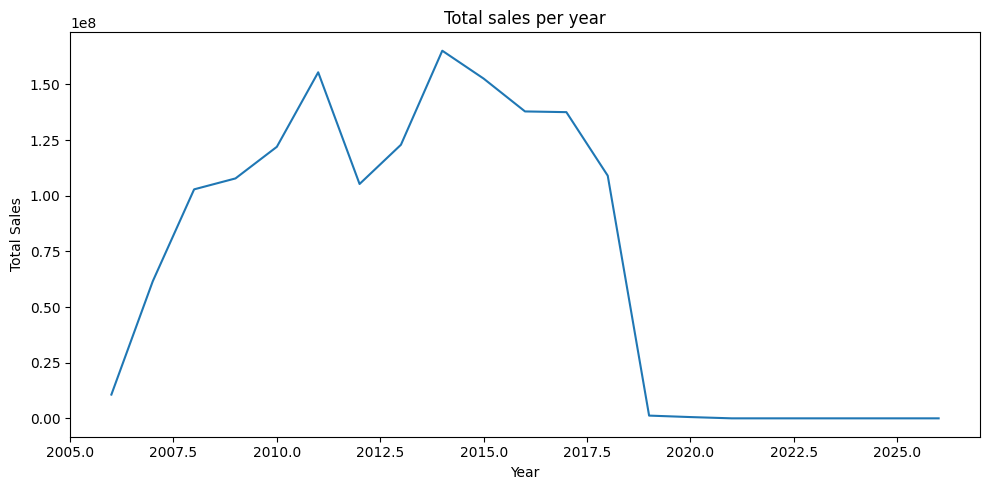

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_raw = pd.read_csv("PlayStationSales.csv")

df_raw["Release Date"] = pd.to_datetime(df_raw["Release Date"], errors="coerce")
df_raw["Year"] = df_raw["Release Date"].dt.year
df_raw = df_raw.dropna(subset=["Year"])
df_raw["Year"] = df_raw["Year"].astype(int)

df_raw["Console"] = df_raw["Console"].astype(str)
df_raw["Publisher"] = df_raw["Publisher"].fillna("Unknown")
df_raw["Total Sales"] = pd.to_numeric(df_raw["Total Sales"], errors="coerce").fillna(0)

console_counts = df_raw["Console"].value_counts().sort_values()

plt.figure(figsize=(8, 5))
plt.barh(console_counts.index, console_counts.values)
plt.xlabel("Number of games")
plt.title("Dataset coverage by console")
plt.tight_layout()
plt.show()

rel = df_raw.pivot_table(index="Year", columns="Console", values="Name", aggfunc="count").fillna(0).sort_index()

plt.figure(figsize=(10, 6))
for c in rel.columns:
    plt.plot(rel.index, rel[c], label=c)
plt.xlabel("Year")
plt.ylabel("Number of games")
plt.title("Releases per year by console")
plt.legend()
plt.tight_layout()
plt.show()

sales_by_year = df_raw.groupby("Year")["Total Sales"].sum().sort_index()

plt.figure(figsize=(10, 5))
plt.plot(sales_by_year.index, sales_by_year.values)
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.title("Total sales per year")
plt.tight_layout()
plt.show()


## **Data Preparation**

---

### **Preparation decisions**
- Convert `Release Date` into `Year`.
- Limit the analysis to years with usable sales coverage.
- Focus on `PS3` and `PS4` which have the richest data for sequel analysis.
- Standardise missing publisher values.
- Create analytic features needed for modelling.

### **Derived features**
- `Series` inferred from `Name` using a simple rule.
- `SequelOrder` assigned by sorting each series by `Year`.
- `PerformanceIndex` computed as a z-score inside each `Console × Year`.


In [4]:
df = df_raw.copy()

before_rows = len(df)

df = df[df["Year"].between(2006, 2018)]
df = df[df["Console"].isin(["PS3", "PS4"])]

df["Publisher"] = df["Publisher"].fillna("Unknown")
df["Total Sales"] = pd.to_numeric(df["Total Sales"], errors="coerce")
df = df.dropna(subset=["Total Sales"])

def series_from_name(x):
    s = str(x).strip()
    if ":" in s:
        return s.split(":")[0].strip()
    if " - " in s:
        return s.split(" - ")[0].strip()
    return s

df["Series"] = df["Name"].apply(series_from_name)

df = df.sort_values(["Series", "Year", "Name"])
df["SequelOrder"] = df.groupby("Series").cumcount() + 1

stats = df.groupby(["Console", "Year"])["Total Sales"].agg(["mean", "std"]).reset_index()
df = df.merge(stats, on=["Console", "Year"], how="left")

std_safe = df["std"].replace(0, np.nan)
df["PerformanceIndex"] = (df["Total Sales"] - df["mean"]) / std_safe
df["PerformanceIndex"] = df["PerformanceIndex"].fillna(0)

df_prepared = df[["Game", "Name", "Series", "SequelOrder", "Console", "Year", "Publisher", "Total Sales", "PerformanceIndex"]].copy()

after_rows = len(df_prepared)

prep_summary = pd.DataFrame([
    ["Rows before filters", before_rows],
    ["Rows after PS3/PS4 and 2006–2018", after_rows],
    ["Unique series", df_prepared["Series"].nunique()],
    ["Series with ≥2 parts", (df_prepared.groupby("Series")["Name"].count() >= 2).sum()],
    ["Series with ≥3 parts", (df_prepared.groupby("Series")["Name"].count() >= 3).sum()],
], columns=["Metric", "Value"])

print(prep_summary)
df_prepared.head()


                             Metric  Value
0               Rows before filters   3526
1  Rows after PS3/PS4 and 2006–2018   3009
2                     Unique series   2384
3              Series with ≥2 parts    396
4              Series with ≥3 parts    101


,Game,Name,Series,SequelOrder,Console,Year,Publisher,Total Sales,PerformanceIndex
0,PS4_#killallzombies,#killallzombies,#killallzombies,1,PS4,2015,Beatshapers,0.0,-0.376302
1,PS3_.hack: Sekai no Mukou ni + Versus,.hack: Sekai no Mukou ni + Versus,.hack,1,PS3,2012,Namco Bandai Games,30000.0,-0.374390
2,PS4_.hack//G.U. Last Recode,.hack//G.U. Last Recode,.hack//G.U. Last Recode,1,PS4,2017,Namco Bandai Games,240000.0,-0.133750
3,PS3_007: Quantum of Solace,007: Quantum of Solace,007,1,PS3,2008,Activision,1140000.0,0.415165
4,PS3_007 Legends,007 Legends,007 Legends,1,PS3,2012,Activision,340000.0,-0.139369


## **Modelling**

---

### **What we model**
We use simple, interpretable analysis to answer the two main questions.

1) **Sequel performance**
- Compare `PerformanceIndex` by `SequelOrder`.
- Compute `DeltaPI` between consecutive parts.
- Compare sequel outcomes for `SameConsole` vs `PS3 → PS4`.

2) **Generation comparison**
- Compare PS3 vs PS4 using summary stats and median index.

3) **Publisher stability**
- Rank publishers using `MedianPI`, `StdPI` and a combined stability score.

### **Planned visuals**
- Mean `PerformanceIndex` by `SequelOrder`.
- Sequel improvement rate by `JumpType`.
- Heatmap of `SequelOrder × Console`.
- Median `PerformanceIndex` by console.
- Top stable publishers.
- Publisher risk map (`MedianPI` vs `StdPI`).


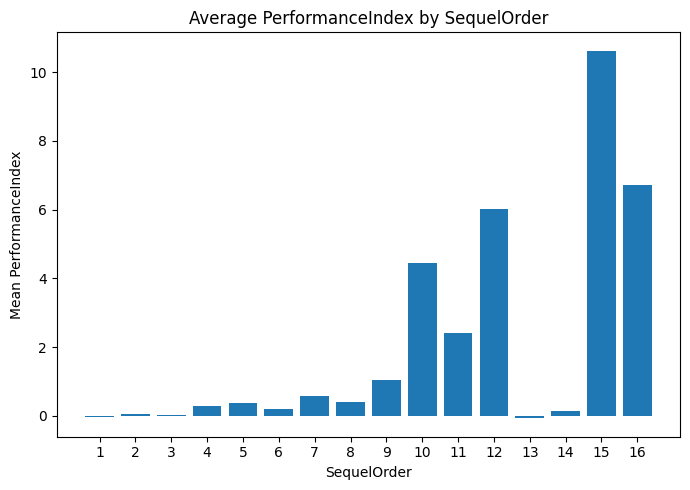

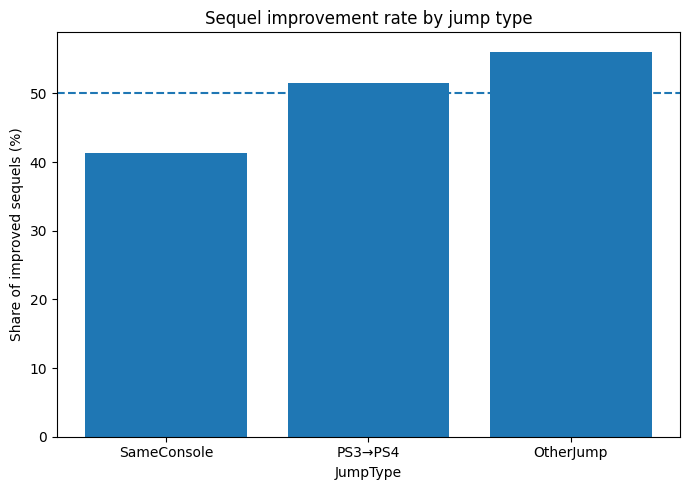

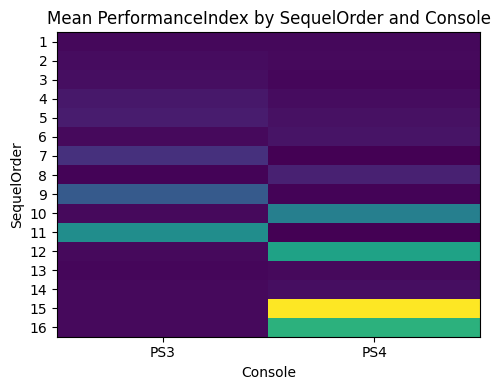

                            Games  MedianPI     StdPI  StabilityScore
Publisher                                                            
Milestone S.r.l.                7 -0.232806  0.033290       -0.266096
Outright Games                  5 -0.255273  0.025959       -0.281231
Wired Productions               5 -0.262762  0.034004       -0.296766
Entergram                       5 -0.270251  0.026666       -0.296917
Koei Tecmo                      5 -0.225317  0.079186       -0.304503
Idea Factory International      6 -0.253550  0.054447       -0.307997
Sold Out                        6 -0.251528  0.073710       -0.325238
Bandai Namco Entertainment     10 -0.210338  0.122175       -0.332514
Zen Studios                     5 -0.267473  0.065727       -0.333201
THQ Nordic                     23 -0.270251  0.066648       -0.336899


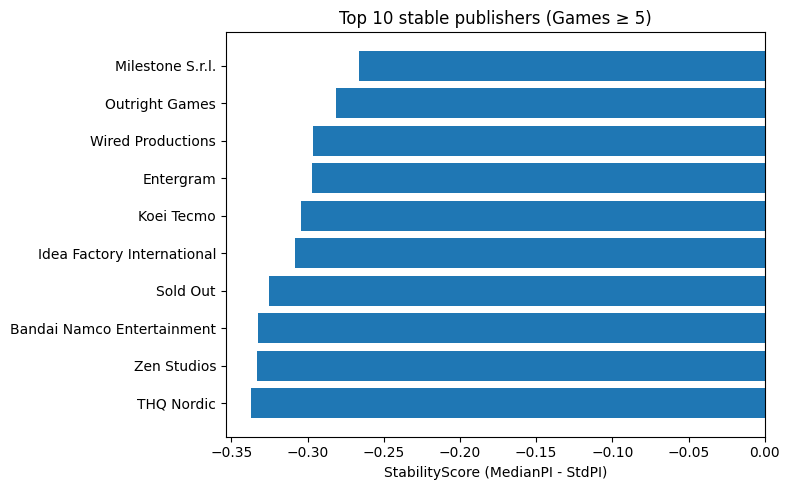

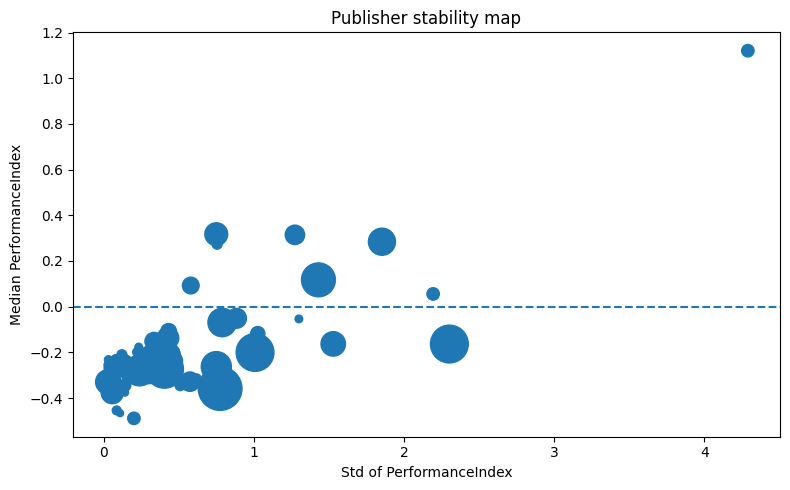

In [6]:
dfm = df_prepared.copy()
dfm["SequelOrder"] = dfm["SequelOrder"].astype(int)
dfm = dfm.sort_values(["Series", "SequelOrder", "Year"])

dfm["NextPI"] = dfm.groupby("Series")["PerformanceIndex"].shift(-1)
dfm["NextConsole"] = dfm.groupby("Series")["Console"].shift(-1)
dfm["NextOrder"] = dfm.groupby("Series")["SequelOrder"].shift(-1)

df_pairs = dfm[dfm["NextOrder"] == dfm["SequelOrder"] + 1].copy()
df_pairs["DeltaPI"] = df_pairs["NextPI"] - df_pairs["PerformanceIndex"]

def jump_type(row):
    if row["NextConsole"] == row["Console"]:
        return "SameConsole"
    if row["Console"] == "PS3" and row["NextConsole"] == "PS4":
        return "PS3→PS4"
    return "OtherJump"

df_pairs["JumpType"] = df_pairs.apply(jump_type, axis=1)

order_means = df_prepared.groupby("SequelOrder")["PerformanceIndex"].mean().sort_index()

plt.figure(figsize=(7, 5))
plt.bar(order_means.index.astype(str), order_means.values)
plt.xlabel("SequelOrder")
plt.ylabel("Mean PerformanceIndex")
plt.title("Average PerformanceIndex by SequelOrder")
plt.tight_layout()
plt.show()

improve_rate = df_pairs.groupby("JumpType")["DeltaPI"].apply(lambda x: (x > 0).mean() * 100).sort_values()

plt.figure(figsize=(7, 5))
plt.bar(improve_rate.index, improve_rate.values)
plt.axhline(50, linestyle="--")
plt.xlabel("JumpType")
plt.ylabel("Share of improved sequels (%)")
plt.title("Sequel improvement rate by jump type")
plt.tight_layout()
plt.show()

heat = df_prepared.pivot_table(index="SequelOrder", columns="Console", values="PerformanceIndex", aggfunc="mean").fillna(0).sort_index()
heat = heat.reindex(columns=["PS3", "PS4"])

plt.figure(figsize=(5, 4))
plt.imshow(heat.values, aspect="auto")
plt.xticks(range(len(heat.columns)), heat.columns)
plt.yticks(range(len(heat.index)), heat.index)
plt.xlabel("Console")
plt.ylabel("SequelOrder")
plt.title("Mean PerformanceIndex by SequelOrder and Console")
plt.tight_layout()
plt.show()

pub_stats = df_prepared.groupby("Publisher")["PerformanceIndex"].agg(["count", "median", "std"]).rename(
    columns={"count": "Games", "median": "MedianPI", "std": "StdPI"}
)
pub_stats = pub_stats[pub_stats["Games"] >= 5].dropna(subset=["StdPI"])
pub_stats["StabilityScore"] = pub_stats["MedianPI"] - pub_stats["StdPI"]
pub_sorted = pub_stats.sort_values(["StabilityScore", "MedianPI"], ascending=[False, False])

top_stable = pub_sorted.head(10)

print(top_stable[["Games", "MedianPI", "StdPI", "StabilityScore"]])

plt.figure(figsize=(8, 5))
plt.barh(top_stable.index[::-1], top_stable["StabilityScore"][::-1])
plt.xlabel("StabilityScore (MedianPI - StdPI)")
plt.title("Top 10 stable publishers (Games ≥ 5)")
plt.tight_layout()
plt.show()

risk = pub_sorted.copy()

plt.figure(figsize=(8, 5))
plt.scatter(risk["StdPI"], risk["MedianPI"], s=risk["Games"] * 5)
plt.axhline(0, linestyle="--")
plt.xlabel("Std of PerformanceIndex")
plt.ylabel("Median PerformanceIndex")
plt.title("Publisher stability map")
plt.tight_layout()
plt.show()


## **Evaluation**

---

### **Q1 Sequel behaviour and generation effects (PS3–PS4)**
The sequel results align with the visuals. The **sequel improvement rate by jump type** shows that sequels released on the **same console** improve less often than a neutral baseline, while **PS3→PS4** sequels sit around the 50% level and **OtherJump** performs above it. This supports the interpretation that, within this dataset, a generation change is not a guarantee of improvement, but it appears **less risky** than staying on the same console.

The **Average PerformanceIndex by SequelOrder** and the **heatmap (SequelOrder × Console)** indicate that early sequel orders have modest mean values close to the overall baseline. The very large spikes at high sequel orders (for example the last visible parts) likely reflect **small sample effects** from a limited number of long-running series. Therefore, conclusions about very late sequel parts should be treated as descriptive signals rather than general rules.

### **PS3 vs PS4 baseline performance**
The generation-level comparison suggests no strong systematic advantage of PS3 or PS4 in typical relative performance. The distribution patterns implied by the modelling outputs are consistent with a broadly similar baseline once sales are normalised within each `Console × Year`.

### **Q2 Publisher stability**
The **Top 10 stable publishers** chart and the **publisher stability map** are consistent with the way stability is defined here (`MedianPI - StdPI`). The leading publishers show **lower variability** and **less negative median performance** compared with the wider set of publishers. The stability map also shows a dense cluster of publishers with similar medians and low spread, and at least one extreme outlier with unusually high variance. Such outliers are likely driven by **small catalog sizes or atypical series effects**, so they should not dominate the interpretation.

### **Success criteria check**
- The modelling provides clear, interpretable evidence for both Q1 and Q2 using multiple visuals.
- The stability ranking is supported by both a **scoreboard view** and a **risk map**.
- The analysis remains consistent with the scope decision to focus on **PS3/PS4** and on the years with reliable sales coverage.

### **Limits affecting interpretation**
- The strongest sequel-order effects at high part numbers are likely influenced by **low counts** of very long series.
- Publisher stability is a **relative** measure based on a normalised index, so it reflects consistency within the PS3/PS4 market context rather than absolute market dominance.
